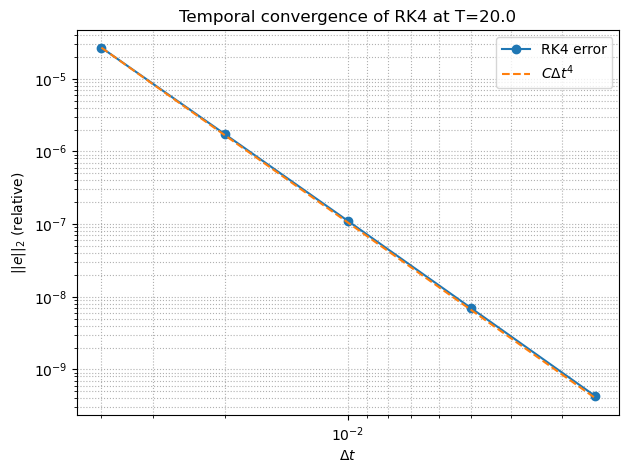

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#3(i) plot 1 Convergence plot

# RK4 integrator (generic)

def rk4_step(f, y, t, dt, params):
    k1 = f(y, t, params)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt, params)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt, params)
    k4 = f(y + dt*k3, t + dt, params)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def integrate_rk4(f, y0, T, dt, params, blowup_norm=1e6):
    """
    Integrate y' = f(y,t) from 0..T with RK4.
    Returns y(T). Raises ValueError if it blows up.
    """
    nsteps = int(np.round(T/dt))
    t = 0.0
    y = y0.astype(float).copy()

    for _ in range(nsteps):
        y = rk4_step(f, y, t, dt, params)
        t += dt

        # blow-up / instability detection
        if (not np.all(np.isfinite(y))) or (np.linalg.norm(y, ord=2) > blowup_norm):
            raise ValueError("Solution blew up (unstable dt or unstable dynamics).")

    return y

def rel_l2_error(y, y_ref, eps=1e-14):
    return np.linalg.norm(y - y_ref) / (np.linalg.norm(y_ref) + eps)

def flutter_rhs(y, t, p):
    h, a, hd, ad = y

    wh = p["omega_h"]
    wa = p["omega_a"]
    zh = p["zeta_h"]
    za = p["zeta_a"]
    kh = p["k_couple"]
    ka = p["a_couple"]
    F0 = p.get("F0", 0.0)
    wf = p.get("omega_f", 0.0)

    # Stable linear coupled oscillator
    hdd = -2*zh*wh*hd - (wh**2)*h - kh*a + F0*np.sin(wf*t)
    add = -2*za*wa*ad - (wa**2)*a - ka*h

    return np.array([hd, ad, hdd, add])


# Temporal convergence test
def rk4_temporal_convergence(f, y0, T, dts,
                             params,
                             dt_ref=1e-4,
                             blowup_norm=1e6):
    # Reference solution
    y_ref = integrate_rk4(f, y0, T, dt_ref, params, blowup_norm=blowup_norm)

    errs = []
    good_dts = []

    for dt in dts:
        try:
            yT = integrate_rk4(f, y0, T, dt, params, blowup_norm=blowup_norm)
            e = rel_l2_error(yT, y_ref)
            if np.isfinite(e) and e > 0:
                good_dts.append(dt)
                errs.append(e)
            else:
                print(f"dt={dt:.5f}: produced non-finite/zero error -> excluded")
        except ValueError as ex:
            print(f"dt={dt:.5f}: {ex} -> excluded")

    good_dts = np.array(good_dts, dtype=float)
    errs = np.array(errs, dtype=float)

    # Observed orders (only for good dt)
    orders = []
    for i in range(len(good_dts) - 1):
        p_obs = np.log(errs[i]/errs[i+1]) / np.log(good_dts[i]/good_dts[i+1])
        orders.append(p_obs)
    orders = np.array(orders)

    return good_dts, errs, orders



T = 20.0
y0 = np.array([0.01, 0.02, 0.0, 0.0])

params = dict(
    omega_h=1.8,
    omega_a=2.4,
    zeta_h=0.05,   # positive damping
    zeta_a=0.05,   # positive damping
    k_couple=1.0,
    a_couple=0.8,
    F0=0.0,
    omega_f=0.0
)


dts = np.array([0.04, 0.02, 0.01, 0.005, 0.0025]) 

good_dts, errs, orders = rk4_temporal_convergence(
    flutter_rhs, y0, T, dts,
    params=params,
    dt_ref=1e-5,    # small enough so ref error is negligible
    blowup_norm=1e6
)


# Plot error + reference slope C dt^4
plt.figure(figsize=(7,5))
plt.loglog(good_dts, errs, 'o-', label='RK4 error')

# scale reference line to match first point
C = errs[0] / (good_dts[0]**4)
plt.loglog(good_dts, C*(good_dts**4), '--', label=r'$C\Delta t^4$')

plt.gca().invert_xaxis() 
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$||e||_2$ (relative)')
plt.title(f'Temporal convergence of RK4 at T={T}')
plt.grid(True, which='both', linestyle=':')
plt.legend(loc='best')
plt.show()

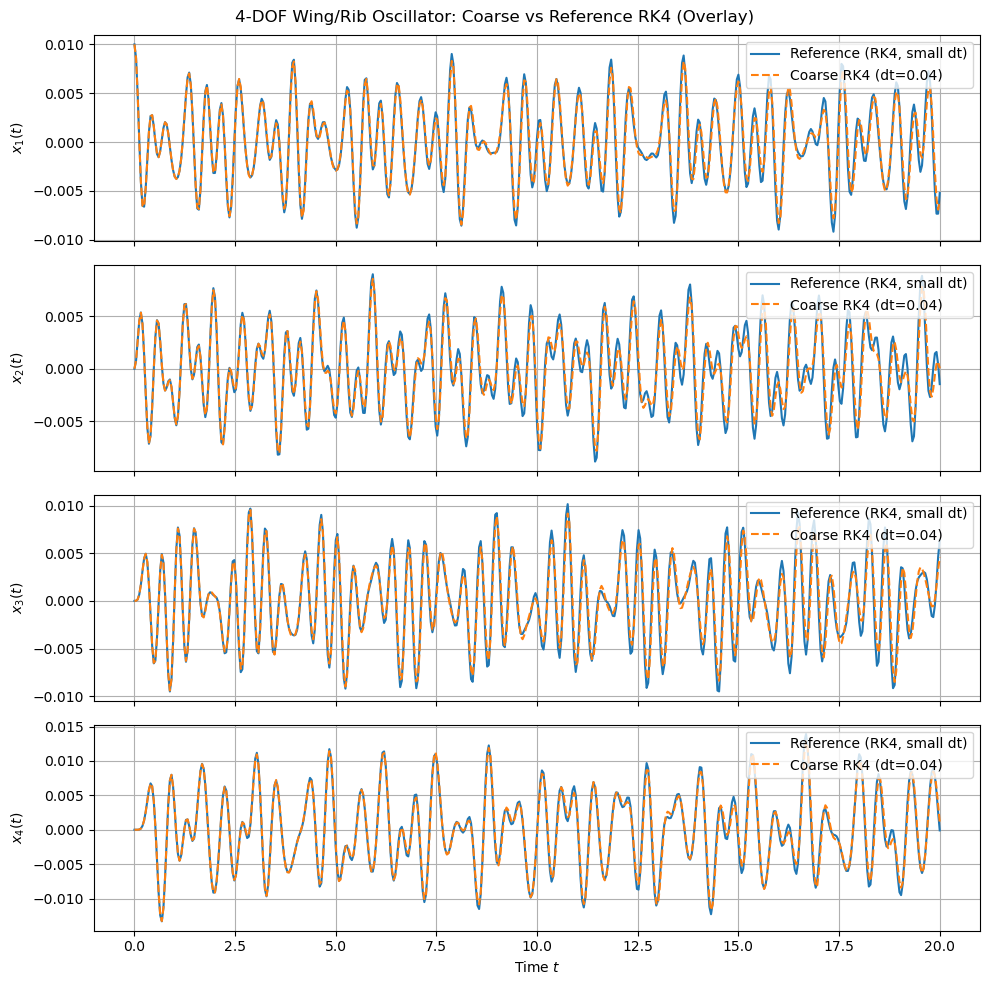

In [2]:

# 3(i) Second plot: coarse vs. reference RK4

import numpy as np
import matplotlib.pyplot as plt

# 4-mass rib/wing spring model:  M xdd + K x = 0
m1, m2, m3, m4 = 1.0, 0.8, 0.6, 0.4
k1, k2, k3, k4 = 100.0, 80.0, 60.0, 40.0

M = np.diag([m1, m2, m3, m4])
K = np.array([
    [ k1+k2,  -k2,     0,      0 ],
    [ -k2,  k2+k3,  -k3,      0 ],
    [  0,    -k3,  k3+k4,   -k4 ],
    [  0,      0,   -k4,    k4 ]
])
Minv = np.linalg.inv(M)

def f(y, t):
    """
    y = [x1,x2,x3,x4, v1,v2,v3,v4]^T
    """
    x = y[:4]
    v = y[4:]
    xdot = v
    vdot = -Minv @ (K @ x)
    return np.concatenate([xdot, vdot])


# RK4 integrator
def rk4_step(f, y, t, dt):
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3, t + dt)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4(f, y0, T, dt):
    N = int(np.round(T/dt))
    t = np.linspace(0.0, N*dt, N+1)
    Y = np.zeros((N+1, len(y0)))
    Y[0] = y0
    y = y0.copy()
    for n in range(N):
        y = rk4_step(f, y, t[n], dt)
        Y[n+1] = y
    return t, Y

# Choose initial condition + timesteps
T = 20.0
dt_coarse = 0.04
dt_ref    = 0.0025 

y0 = np.array([
    0.01, 0.0, 0.0, 0.0,   
    0.0,  0.0, 0.0, 0.0   
])

tC, YC = simulate_rk4(f, y0, T, dt_coarse)
tR, YR = simulate_rk4(f, y0, T, dt_ref)
XC = YC[:, :4]
XR = YR[:, :4]

# Sample the reference solution at the coarse time grid
idx = np.round(tC / dt_ref).astype(int)
idx = np.clip(idx, 0, len(tR)-1)
XR_on_coarse = XR[idx, :]


# Plot: overlay coarse vs reference for all 4 masses
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    axes[i].plot(tC, XR_on_coarse[:, i], label="Reference (RK4, small dt)")
    axes[i].plot(tC, XC[:, i], "--", label=f"Coarse RK4 (dt={dt_coarse})")
    axes[i].set_ylabel(f"$x_{i+1}(t)$")
    axes[i].grid(True)
    axes[i].legend(loc="upper right")

axes[-1].set_xlabel("Time $t$")
plt.suptitle("4-DOF Wing/Rib Oscillator: Coarse vs Reference RK4 (Overlay)")
plt.tight_layout()
plt.show()


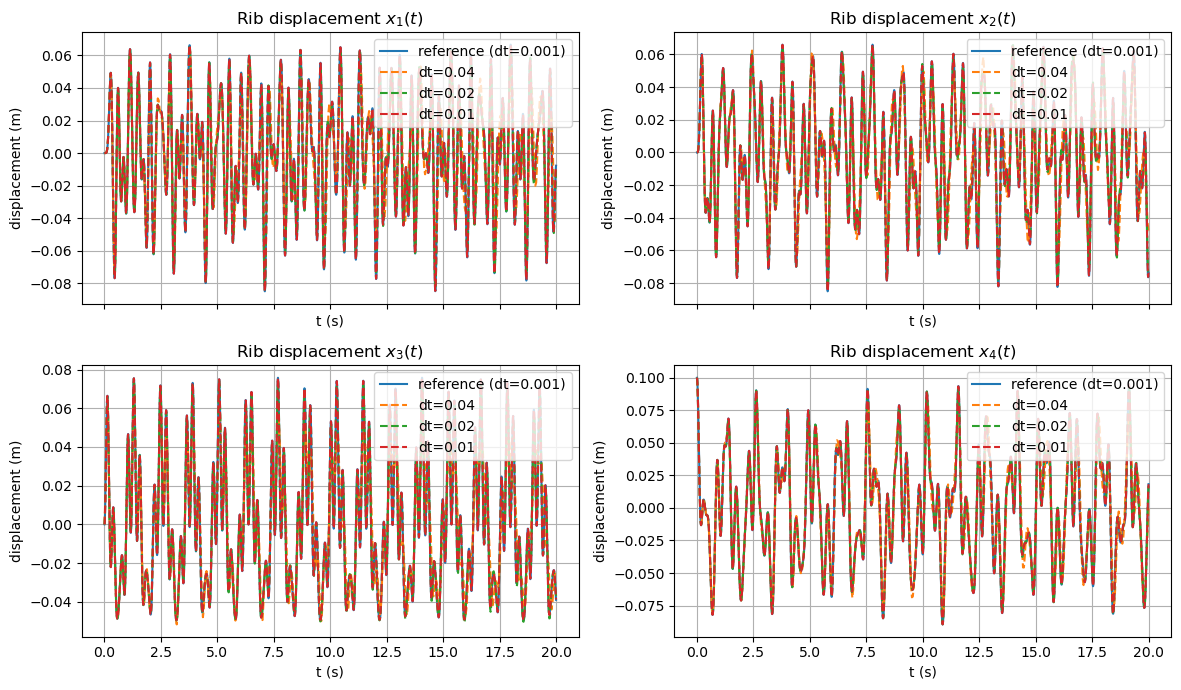

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 3(ii) Plot 1: Time-step sensitivity (RK4) on 4-DOF wing/rib model


#4-DOF chain model (rib masses connected by springs)
def build_4dof_chain(m=1.0, k=200.0):
    """
    4 masses in a line with springs:
      wall --k-- m1 --k-- m2 --k-- m3 --k-- m4
    """
    M = m * np.eye(4)
    K = np.array([
        [ 2*k, -k,   0,   0],
        [ -k,  2*k, -k,   0],
        [  0,  -k,  2*k, -k],
        [  0,   0,  -k,   k]
    ], dtype=float)
    return M, K

def make_first_order_rhs(M, K):
    """
    Converts M xdd + K x = 0 into u' = f(u),
    where u = [x; v], x,v in R^4.
    """
    Minv = np.linalg.inv(M)

    def f(u, t):
        x = u[:4]
        v = u[4:]
        a = -Minv @ (K @ x)
        return np.concatenate([v, a])

    return f

#RK4 integrator
def rk4_step(f, y, t, dt):
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3, t + dt)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4(f, y0, T, dt):
    N = int(np.round(T/dt))
    t = np.linspace(0.0, N*dt, N+1)
    Y = np.zeros((N+1, len(y0)))
    Y[0, :] = y0
    y = y0.copy()
    for k in range(N):
        y = rk4_step(f, y, t[k], dt)
        Y[k+1, :] = y
    return t, Y

#Build model + initial condition 
M, K = build_4dof_chain(m=1.0, k=200.0)
f = make_first_order_rhs(M, K)

T = 20.0

# Initial condition, small tip displacement, rest at zero, zero velocities
x0 = np.array([0.0, 0.0, 0.0, 0.10])   # m
v0 = np.zeros(4)                       # m/s
y0 = np.concatenate([x0, v0])

#Reference solution
dt_ref = 0.001
t_ref, Y_ref = simulate_rk4(f, y0, T, dt_ref)
X_ref = Y_ref[:, :4]  # displacements

#coarse dt values to test
dt_list = [0.04, 0.02, 0.01]  # you can add 0.005 etc.

# Plot: 4 subplots (x1..x4)
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)
axes = axes.ravel()

for i in range(4):
    ax = axes[i]

    ax.plot(t_ref, X_ref[:, i], label=f"reference (dt={dt_ref})")

    for dt in dt_list:
        t_c, Y_c = simulate_rk4(f, y0, T, dt)
        X_c = Y_c[:, :4]


        ax.plot(t_c, X_c[:, i], linestyle="--", label=f"dt={dt}")

    ax.set_title(f"Rib displacement $x_{i+1}(t)$")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("displacement (m)")
    ax.legend(loc="upper right")  
    ax.grid(True)

plt.tight_layout()
plt.show()


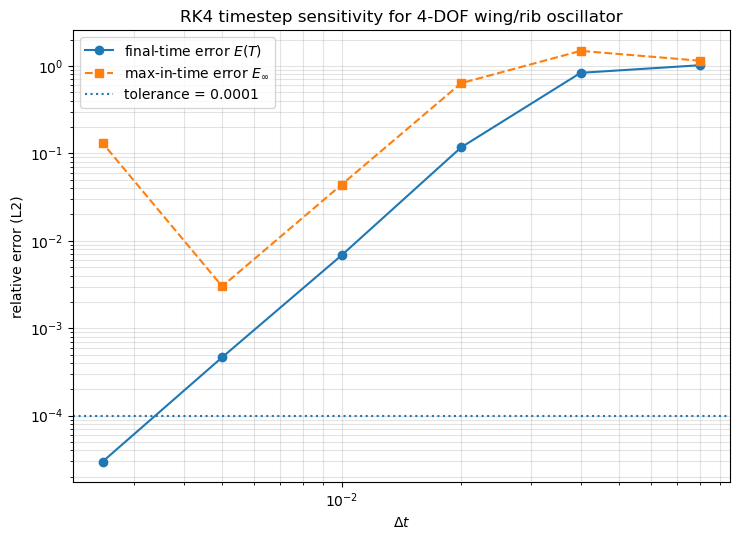

In [5]:
# 3(ii) Plot 2: timestep-size sensitivity (error vs Δt) + tolerance line

import numpy as np
import matplotlib.pyplot as plt

T = 20.0

# 4-DOF rib chain parameters 
m1 = 1.0                
mass_ratio = 0.8        
k1 = 200.0             
stiffness_ratio = 0.85  

# initial condition
d_tip = 0.01            # meters
x0 = np.array([0.0, 0.0, 0.0, d_tip])
v0 = np.zeros(4)


dts = np.array([0.08, 0.04, 0.02, 0.01, 0.005, 0.0025])
dt_ref = 0.001

# tolerance line 
tol = 1e-4


# Build M, K for 4-DOF rib chain
m2 = mass_ratio * m1
m3 = mass_ratio * m2
m4 = mass_ratio * m3
M = np.diag([m1, m2, m3, m4])

k2 = stiffness_ratio * k1
k3 = stiffness_ratio * k2
k4 = stiffness_ratio * k3

K = np.array([
    [k1 + k2,   -k2,     0.0,    0.0],
    [ -k2,    k2 + k3,  -k3,     0.0],
    [ 0.0,     -k3,    k3 + k4,  -k4],
    [ 0.0,      0.0,    -k4,      k4]
], dtype=float)

Minv = np.linalg.inv(M)

# First-order ODE: u = [x; v]
# u' = [v; -M^{-1}K x]
def f(u, t):
    x = u[:4]
    v = u[4:]
    a = -(Minv @ (K @ x))
    return np.hstack([v, a])

def rk4_step(fun, u, t, dt):
    k1 = fun(u, t)
    k2 = fun(u + 0.5*dt*k1, t + 0.5*dt)
    k3 = fun(u + 0.5*dt*k2, t + 0.5*dt)
    k4 = fun(u + dt*k3, t + dt)
    return u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4(fun, u0, T, dt):
    nsteps = int(np.ceil(T/dt))
    t = np.linspace(0.0, nsteps*dt, nsteps+1)
    u = np.zeros((nsteps+1, len(u0)))
    u[0] = u0.copy()
    for k in range(nsteps):
        u[k+1] = rk4_step(fun, u[k], t[k], dt)
    return t, u

u0 = np.hstack([x0, v0])
tR, uR = simulate_rk4(f, u0, T, dt_ref)


# Error metrics:
#   (A) Final-time relative L2 error
#   (B) Max-in-time relative L2 error over [0,T]
# We compare by sampling the reference at the coarse time grid (nearest index).
def nearest_ref(u_ref, t_ref, t_query):
    # nearest-neighbor index mapping
    idx = np.searchsorted(t_ref, t_query)
    idx = np.clip(idx, 1, len(t_ref)-1)
    left = idx - 1
    right = idx
    choose_right = (t_query - t_ref[left]) > (t_ref[right] - t_query)
    return u_ref[left] * (~choose_right)[:,None] + u_ref[right] * (choose_right)[:,None]

errs_final = []
errs_max = []

for dt in dts:
    tC, uC = simulate_rk4(f, u0, T, dt)

    uR_on_C = nearest_ref(uR, tR, tC)

    # relative L2 at each time
    num = np.linalg.norm(uC - uR_on_C, axis=1)
    den = np.linalg.norm(uR_on_C, axis=1)
    rel = num / np.maximum(den, 1e-14)

    errs_final.append(rel[-1])
    errs_max.append(np.max(rel))

errs_final = np.array(errs_final)
errs_max = np.array(errs_max)

# Plot: error vs dt with tolerance line
plt.figure(figsize=(7.5, 5.5))
plt.loglog(dts, errs_final, marker='o', label=r'final-time error $E(T)$')
plt.loglog(dts, errs_max, marker='s', linestyle='--', label=r'max-in-time error $E_\infty$')
plt.axhline(tol, linestyle=':', label=fr'tolerance = {tol:g}')

plt.xlabel(r'$\Delta t$')
plt.ylabel('relative error (L2)')
plt.title('RK4 timestep sensitivity for 4-DOF wing/rib oscillator')
plt.grid(True, which='both', alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()




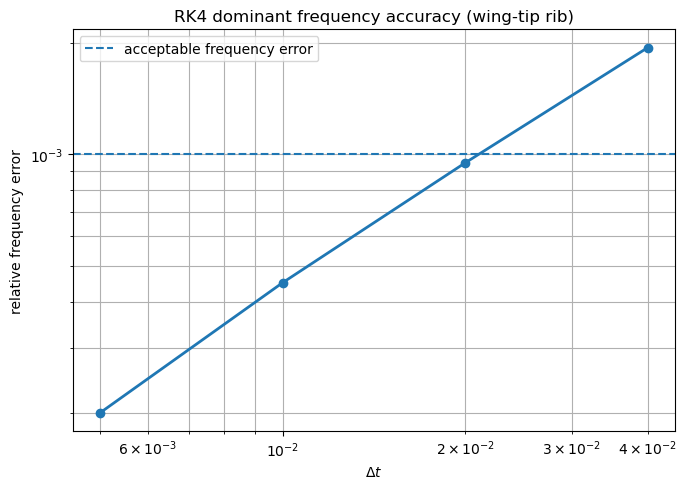

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#3ii plot 3 relative frequency error

# Helper function dominant frequency via FFT
def dominant_frequency(t, x):
    """
    Estimate dominant angular frequency from time signal x(t)
    using FFT (excluding zero-frequency component).
    """
    dt = t[1] - t[0]
    x = x - np.mean(x)                
    N = len(x)

    freqs = np.fft.rfftfreq(N, dt)
    fft_vals = np.abs(np.fft.rfft(x))

    # Ignore zero frequency
    idx = np.argmax(fft_vals[1:]) + 1
    omega = 2 * np.pi * freqs[idx]
    return omega


T = 20.0
dt_list = [0.04, 0.02, 0.01, 0.005]
dt_ref = 0.001   # reference timestep

# Initial condition
y0 = np.zeros(8)
y0[0] = 0.01    


t_ref, Y_ref = simulate_rk4(f, y0, T, dt_ref)
x4_ref = Y_ref[:, 3]
omega_ref = dominant_frequency(t_ref, x4_ref)


omega_num = []
rel_freq_err = []

for dt in dt_list:
    t, Y = simulate_rk4(f, y0, T, dt)
    x4 = Y[:, 3]

    omega = dominant_frequency(t, x4)
    omega_num.append(omega)

    rel_err = abs(omega - omega_ref) / omega_ref
    rel_freq_err.append(rel_err)

# Plot
plt.figure(figsize=(7, 5))
plt.loglog(dt_list, rel_freq_err, 'o-', linewidth=2)
plt.axhline(1e-3, linestyle='--', label='acceptable frequency error')

plt.xlabel(r'$\Delta t$')
plt.ylabel('relative frequency error')
plt.title('RK4 dominant frequency accuracy (wing-tip rib)')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


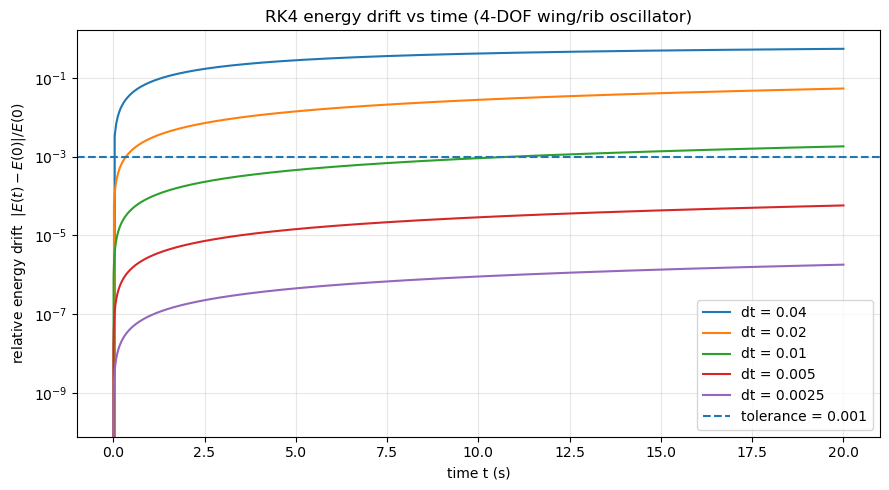

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#3ii plot 4 energy drift vs time 
# RK4 energy-drift check (4-DOF wing/rib oscillator)


#Define the 4-DOF rib/wing oscillator
m1, m2, m3, m4 = 1.0, 0.8, 0.6, 0.5
M = np.diag([m1, m2, m3, m4])

k1, k2, k3, k4 = 200.0, 160.0, 120.0, 90.0
K = np.array([
    [k1 + k2,   -k2,      0.0,     0.0],
    [-k2,     k2 + k3,   -k3,      0.0],
    [0.0,      -k3,     k3 + k4,   -k4],
    [0.0,       0.0,     -k4,       k4]
], dtype=float)

Minv = np.linalg.inv(M)

#Convert M xdd + K x = 0 into first-order y' = f(y,t), y=[x;v]
def f(y, t):
    x = y[:4]
    v = y[4:]
    a = -Minv @ (K @ x)
    return np.hstack([v, a])

def rk4_step(fun, y, t, dt):
    k1 = fun(y, t)
    k2 = fun(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = fun(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = fun(y + dt*k3,     t + dt)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4(fun, y0, T, dt):
    nsteps = int(np.round(T/dt))
    t = np.linspace(0.0, nsteps*dt, nsteps+1)
    y = np.array(y0, dtype=float)
    Y = np.zeros((nsteps+1, len(y0)))
    Y[0] = y
    for k in range(nsteps):
        y = rk4_step(fun, y, t[k], dt)
        Y[k+1] = y
    return t, Y

#Energy E(t) = 1/2 v^T M v + 1/2 x^T K x
def energy(Y):
    x = Y[:, :4]
    v = Y[:, 4:]
    kin = 0.5*np.einsum('bi,ij,bj->b', v, M, v)
    pot = 0.5*np.einsum('bi,ij,bj->b', x, K, x)
    return kin + pot

#Initial condition: small tip displacement, zero velocity
x0 = np.array([0.0, 0.0, 0.0, 0.05])   # 5 cm at tip rib
v0 = np.zeros(4)
y0 = np.hstack([x0, v0])

#Runs and plot energy drift for several dt
T = 20.0
dts = [0.04, 0.02, 0.01, 0.005, 0.0025]

plt.figure(figsize=(9, 5))
for dt in dts:
    t, Y = simulate_rk4(f, y0, T, dt)
    E = energy(Y)
    rel_drift = np.abs(E - E[0]) / (E[0] if E[0] != 0 else 1.0)
    plt.plot(t, rel_drift, label=f"dt = {dt:g}")

tol = 1e-3
plt.axhline(tol, linestyle='--', label=f"tolerance = {tol:g}")

plt.yscale('log')
plt.xlabel("time t (s)")
plt.ylabel(r"relative energy drift  $|E(t)-E(0)|/E(0)$")
plt.title("RK4 energy drift vs time (4-DOF wing/rib oscillator)")
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


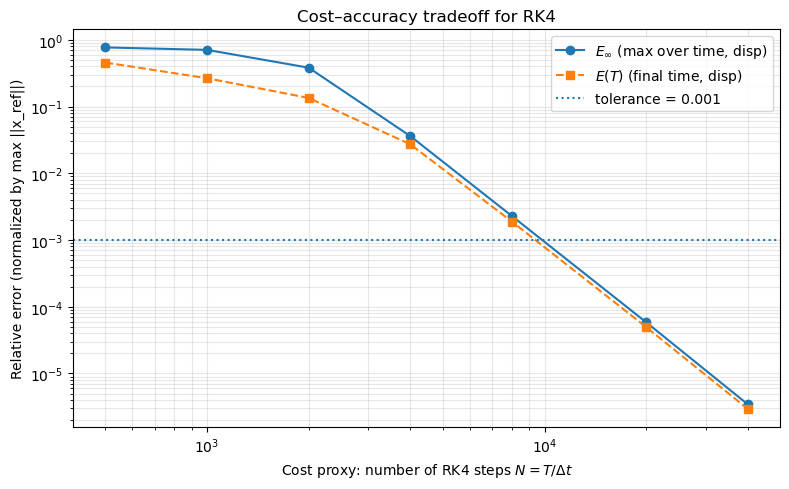

In [7]:
#3ii plot 5 RK4 cost–accuracy tradeoff 
import numpy as np
import matplotlib.pyplot as plt


# 1) Define the 4-DOF model
#    M xdd + K x = 0  ->  u = [x; v],  u' = f(u)
def build_4dof_mk(m1=1.0, mass_ratio=0.8, k1=1200.0, stiff_decay=0.85):
    """
    Simple rib chain:
      masses m1..m4 decrease by mass_ratio each rib
      springs k1..k4 decrease by stiff_decay each bay
    Returns M (4x4), K (4x4)
    """
    m2 = mass_ratio * m1
    m3 = mass_ratio * m2
    m4 = mass_ratio * m3
    M = np.diag([m1, m2, m3, m4])

    k2 = stiff_decay * k1
    k3 = stiff_decay * k2
    k4 = stiff_decay * k3
    K = np.array([
        [k1 + k2,   -k2,      0.0,     0.0],
        [-k2,     k2 + k3,   -k3,      0.0],
        [0.0,       -k3,    k3 + k4,   -k4],
        [0.0,       0.0,     -k4,       k4],
    ])
    return M, K

def rk4_step(f, y, t, dt):
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3,     t + dt)
    return y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4(f, y0, T, dt):
    nsteps = int(np.round(T/dt))

    t = np.linspace(0.0, nsteps*dt, nsteps+1)
    y = np.zeros((nsteps+1, len(y0)))
    y[0] = y0
    for k in range(nsteps):
        y[k+1] = rk4_step(f, y[k], t[k], dt)
    return t, y

#Problem setup
M, K = build_4dof_mk(m1=1.0, mass_ratio=0.8, k1=1200.0, stiff_decay=0.85)
Minv = np.linalg.inv(M)

def f(u, t):
    x = u[:4]
    v = u[4:]
    a = -Minv @ (K @ x)
    return np.hstack([v, a])

T = 20.0
# initial displacement at the wing tip rib (mass 4), zero velocities
x0 = np.array([0.0, 0.0, 0.0, 0.01])
v0 = np.zeros(4)
u0 = np.hstack([x0, v0])

# dt choices
dt_list = np.array([0.04, 0.02, 0.01, 0.005, 0.0025, 0.001, 0.0005])

# reference 
dt_ref = 0.00025
t_ref, u_ref = simulate_rk4(f, u0, T, dt_ref)
x_ref = u_ref[:, :4]  # displacement-only


ref_scale = np.max(np.linalg.norm(x_ref, axis=1))
ref_scale = max(ref_scale, 1e-14)  # safety

def sample_ref_at(t_query):
    # dt_ref divides all dt_list nicely if you picked it that way.
    idx = np.round(t_query/dt_ref).astype(int)
    idx = np.clip(idx, 0, len(t_ref)-1)
    return x_ref[idx]

E_T = []
E_inf = []
N_steps = []

for dt in dt_list:
    t, u = simulate_rk4(f, u0, T, dt)
    x = u[:, :4]

    xR = sample_ref_at(t)

    # final-time relative L2 error (displacement)
    eT = np.linalg.norm(x[-1] - xR[-1]) / ref_scale

    # max-in-time relative error (displacement), with fixed normalization
    e_inf = np.max(np.linalg.norm(x - xR, axis=1)) / ref_scale

    E_T.append(eT)
    E_inf.append(e_inf)
    N_steps.append(int(np.round(T/dt)))

E_T = np.array(E_T)
E_inf = np.array(E_inf)
N_steps = np.array(N_steps)


#Plots cost vs accuracy

tol = 1e-3

plt.figure(figsize=(8,5))
plt.loglog(N_steps, E_inf, 'o-', label=r'$E_\infty$ (max over time, disp)')
plt.loglog(N_steps, E_T,   's--', label=r'$E(T)$ (final time, disp)')
plt.axhline(tol, linestyle=':', label=fr'tolerance = {tol:g}')

plt.xlabel(r'Cost proxy: number of RK4 steps $N = T/\Delta t$')
plt.ylabel('Relative error (normalized by max ||x_ref||)')
plt.title('Cost–accuracy tradeoff for RK4')

plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()
